# LOAY RASHID 2018102008

In [1]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,precision_score,log_loss  
import torch.nn as nn
import torch.nn.functional as F 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Dataset Download

In [2]:
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/foodc/v0.1/train_images.zip
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/foodc/v0.1/test_images.zip
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/foodc/v0.1/train.csv
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/foodc/v0.1/test.csv

!mkdir data
!mkdir data/test
!mkdir data/train
!unzip train_images -d data/train
!unzip test_images -d data/test

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train_images/22d805cf15.jpg  
  inflating: data/train/train_images/145896eed0.jpg  
  inflating: data/train/train_images/c468193dfd.jpg  
  inflating: data/train/train_images/7c6dccda37.jpg  
  inflating: data/train/train_images/c03811cd27.jpg  
  inflating: data/train/train_images/f04e23613b.jpg  
  inflating: data/train/train_images/d1cbbc1134.jpg  
  inflating: data/train/train_images/d762ff4fd3.jpg  
  inflating: data/train/train_images/1df8826db5.jpg  
  inflating: data/train/train_images/4f05c60d04.jpg  
  inflating: data/train/train_images/1b33d95837.jpg  
  inflating: data/train/train_images/fa3e225fe7.jpg  
  inflating: data/train/train_images/7bcd015a19.jpg  
  inflating: data/train/train_images/a413778c2b.jpg  
  inflating: data/train/train_images/4945972217.jpg  
  inflating: data/train/train_images/5245cffff8.jpg  
  inflating: data/train/train_images/6012b508f4.jpg  
  inflating: data/train/train_i

# Custom Dataloader:

In [13]:
class FoodData(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None,train=True):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img_name,label = self.data_list.iloc[item]
        else:
          img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(128,128))
        if self.transform is not None:
            img = self.transform(img)
        if self.train:
          return {
              'gt' : img,
              'label' : torch.tensor(label)
          }
        else:
          return {
              'gt':img
          }

In [14]:
train = pd.read_csv('train.csv')
le = preprocessing.LabelEncoder()
targets = le.fit_transform(train['ClassName'])
ntrain = train
ntrain['ClassName'] = targets  

In [15]:
# test_path = 'data/test/test_images'
# test = pd.read_csv('test.csv')
# test_data = FoodData(data_list= test,data_dir = test_path,transform = transforms_test,train=False)

# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Net Training Code

In [17]:
def dataPreprocess(transform=None, validation_sz=0.2, batch=64, train_path='/content/data/train/train_images'):
    if transform==None:
        transforms_train = transforms.Compose([
        transforms.ToPILImage(),    
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
        ])
    else:
        transforms_train = transform
    train_data = FoodData(data_list= ntrain, data_dir = train_path, transform = transforms_train)

    num = train_data.__len__()
    # Dividing the indices for train and cross validation
    indices = list(range(num))
    np.random.shuffle(indices)
    split = int(np.floor(validation_sz*num))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

    return DataLoader(train_data, batch_size = batch, sampler = train_sampler), DataLoader(train_data, batch_size = batch, sampler = valid_sampler)

In [18]:
def train(model, error, optimizer, train_loader, valid_loader, modelPath = 'best_model_so_far.pth', batch=64, n_epochs=3, transforms=None, train_path='/content/train_images'):
    valid_loss_min = np.Inf

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for images in train_loader:
            data = images['gt'].squeeze(0).to(device)
            # data = data.squeeze(0)
            target = images['label'].to(device)
    #             clear the gradients of all optimized variables
            optimizer.zero_grad()
    #         forward pass the model
            output = model(data)
    #     backward pass the model
            loss = error(output,target)
            loss.backward()
    #         Perform a single optimization step
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        model.eval()
        for images in valid_loader:
            data = images['gt'].squeeze(0).to(device)
            target = images['label'].to(device)
    #         forward pass now
            output = model(data)
    #         calculate the branch loss
            loss = error(output, target)
    #     update average validation loss
            valid_loss += loss.item()*data.size(0)
        
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        print('=' * 10)
        
        if valid_loss <= valid_loss_min:
            print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), modelPath)
    return train_losses, valid_losses

In [19]:
def calcAcc(model, valid_loader, modelPath):
    model.load_state_dict(torch.load(modelPath))
    model.eval() 
    correct = 0
    total = 0
    pred_list = []
    correct_list = []
    with torch.no_grad():
        for images in valid_loader:
            data = images['gt'].squeeze(0).to(device)
            target = images['label'].to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            pr = predicted.detach().cpu().numpy()
            for i in pr:
                pred_list.append(i)
            tg = target.detach().cpu().numpy()
            for i in tg:
                correct_list.append(i)
            correct += (predicted == target).sum().item()

    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    print("F1 score :",f1_score(correct_list,pred_list,average='micro'))

In [20]:
def main(epochs = 5, modelPath = 'basicNet2.pth', modelType = 'basicNet', optimizerType = 'Adam', transform = None):
    print("preprocessing")
    train_loader, valid_loader = dataPreprocess(transform = transform)
    error = nn.CrossEntropyLoss().to(device)

    if modelType=='basicNet':
        model = plainNet().to(device)
    elif modelType=='bnNet':
        model = bnNet().to(device)
    elif modelType=='layerNet':
        model = layerNet().to(device)
    elif modelType=='dropoutNet':
        model = dropoutNet().to(device)
    elif modelType=='maxpoolNet':
        model = maxpoolNet().to(device)
    elif modelType=='activationNet':
        model = activationNet().to(device)        
    
    if optimizerType=='Adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizerType=='SGD':
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

    if(not os.path.exists(modelPath)):
        print("training")
        # train_losses, valid_losses, train_acc, valid_acc = train(model, error, optimizer, train_loader, valid_loader, modelPath = modelPath, n_epochs=epochs)
        train_losses, valid_losses = train(model, error, optimizer, train_loader, valid_loader, modelPath = modelPath, n_epochs=epochs)
        
    calcAcc(model, valid_loader, modelPath)
    plot_graphs(train_losses, valid_losses)

In [21]:
def plot_graphs(train_losses, valid_losses):
    plt.plot(train_losses)
    plt.plot(valid_losses)
    plt.legend(["Train loss", "Validation loss"])

In [22]:
def plotgraphs_new(train_losses, valid_losses, old_train_losses, old_valid_losses):
    fig, ax = plt.subplots(1, 2,figsize=(10,10))
    ax[0].plot(train_losses)
    ax[0].plot(old_train_losses)
    ax[0].legend(["New Train Loss","Old Train Loss"])

    ax[1].plot(valid_losses)
    ax[1].plot(old_valid_losses)
    ax[1].legend(["New Valid Loss","Old Valid Loss"])

# Networks


#### plainNet
Plain neural network, 2 convolutional layers with 6,16 outputs. 

In [15]:
class plainNet(nn.Module):
    #19600 parameters
  # Define layers here
    def __init__(self):
        super(plainNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=3)
        self.conv2 = nn.Conv2d(6, 16, 7)
        # self.conv3 = nn.Conv2d(16, 64, 5)
        self.fc1 = nn.Linear(19600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        # x = F.relu(self.conv3(x))
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### bnNet

Batch Norm standardizes the inputs to a layer for each mini-batch we consider.
This stabilizes the learning process and reduces the number of epochs required to sufficiently train the network. It can also reduce the effects of overfitting and it works well with generalized data.

Effectively, BN reduces the internal covariate shift of the data.

In [16]:
class bnNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(bnNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=3)
        self.bn1 = nn.BatchNorm2d(num_features = 6)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.bn2 = nn.BatchNorm2d(num_features = 16)
        # self.conv3 = nn.Conv2d(16, 64, 5)

        self.fc1 = nn.Linear(19600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 64 * 61 * 61)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### layerNet

Increasing the hidden layers of the networks increases the number of trainable parameters in the model. How ever, this may lead to overfitting.

In [17]:
class layerNet(nn.Module):
    #28800 parameters
  # Define layers here
    def __init__(self):
        super(layerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=4)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.conv3 = nn.Conv2d(16, 64, 7)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(28800, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### dropoutNet

Dropout is a regularization method where you drop (ignore) some number of layer outputs. This gives the effect of training different networks on the same dataset (as the number of active nodes is changing).

In [18]:
class dropoutNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(dropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=3)
        self.conv2 = nn.Conv2d(6, 16, 7)
        # self.conv3 = nn.Conv2d(16, 64, 5)
        self.d1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(19600, 120)
        self.d1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.d1(x)
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### maxpoolNet


Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network.
The pooling layer summarises the features present in a region of the feature map generated by a convolution layer. So, further operations are performed on summarised features instead of precisely positioned features generated by the convolution layer. This makes the model more robust to variations in the position of the features in the input image.

Max pooling is used here, which sets the value to the maximum of the kernel size.

In [19]:
class maxpoolNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(maxpoolNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 6, 7, stride=3)
        self.conv1 = nn.Conv2d(3, 6, 7)
        # self.max1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.max2 = nn.MaxPool2d(kernel_size=3)
        # self.conv3 = nn.Conv2d(16, 64, 5)
        self.fc1 = nn.Linear(23104, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        # x = self.max1(x)
        x = F.relu(self.conv2(x))
        x = self.max2(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### activationNet

In [23]:
class activationNet(nn.Module):
    #19600 parameters
  # Define layers here
    def __init__(self):
        super(activationNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=3)
        self.conv2 = nn.Conv2d(6, 16, 7)
        # self.conv3 = nn.Conv2d(16, 64, 5)
        self.fc1 = nn.Linear(19600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
        self.sof = nn.Softmax(dim = 1)

    def forward(self, x):
      # Forward pass
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        # x = F.relu(self.conv3(x))
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sof(x)
        return x

# ACCURACIES

#### basicNet

In [37]:
epochs = 5
train_loader, valid_loader = dataPreprocess(None)
error = nn.CrossEntropyLoss().to(device)
model = plainNet().to(device)

optimizer = optim.Adam(model.parameters())

old_train_losses, old_valid_losses, old_train_acc, old_valid_acc = train(model, error, optimizer, train_loader, valid_loader, modelPath = "dont_download.pth", n_epochs=epochs)

Epoch: 0 	Training Loss: 3.634934 	Validation Loss: 3.379434
Validation Loss decreased inf -> 3.379434
Epoch: 1 	Training Loss: 3.209598 	Validation Loss: 3.176430
Validation Loss decreased 3.379434 -> 3.176430
Epoch: 2 	Training Loss: 3.005624 	Validation Loss: 3.070373
Validation Loss decreased 3.176430 -> 3.070373
Epoch: 3 	Training Loss: 2.745897 	Validation Loss: 3.004484
Validation Loss decreased 3.070373 -> 3.004484
Epoch: 4 	Training Loss: 2.448237 	Validation Loss: 3.102372


In [48]:
np.save("old_train_losses.npy",np.asarray(old_train_losses))
np.save("old_valid_losses.npy",np.asarray(old_valid_losses))
np.save("old_train_acc.npy",np.asarray(old_train_acc))
np.save("old_valid_acc.npy",np.asarray(old_valid_acc))

[3.379434322594573,
 3.1764304955118203,
 3.070373443063237,
 3.0044841694729523,
 3.1023723168434505]

preprocessing
training
Epoch: 0 	Training Loss: 3.698606 	Validation Loss: 3.428353
Validation Loss decreased inf -> 3.428353
Epoch: 1 	Training Loss: 3.302757 	Validation Loss: 3.189318
Validation Loss decreased 3.428353 -> 3.189318
Epoch: 2 	Training Loss: 3.060050 	Validation Loss: 3.109368
Validation Loss decreased 3.189318 -> 3.109368
Epoch: 3 	Training Loss: 2.887918 	Validation Loss: 3.041662
Validation Loss decreased 3.109368 -> 3.041662
Epoch: 4 	Training Loss: 2.686069 	Validation Loss: 3.020314
Validation Loss decreased 3.041662 -> 3.020314
Epoch: 5 	Training Loss: 2.422390 	Validation Loss: 3.080412
Epoch: 6 	Training Loss: 2.114311 	Validation Loss: 3.144411
Accuracy of the network on the 10000 test images: 24.141631 %
F1 score : 0.24141630901287553


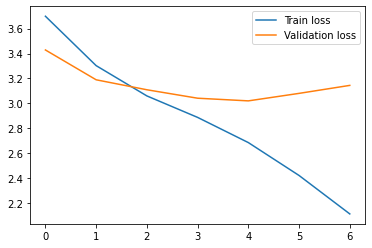

In [20]:
main(epochs=7)

#### Batch Normalization

preprocessing
training
Epoch: 0 	Training Loss: 3.522736 	Validation Loss: 3.214881
Validation Loss decreased inf -> 3.214881
Epoch: 1 	Training Loss: 2.564092 	Validation Loss: 3.247631
Epoch: 2 	Training Loss: 1.441387 	Validation Loss: 3.653911
Epoch: 3 	Training Loss: 0.472586 	Validation Loss: 4.309752
Epoch: 4 	Training Loss: 0.114715 	Validation Loss: 4.833159
Epoch: 5 	Training Loss: 0.043842 	Validation Loss: 5.051917
Epoch: 6 	Training Loss: 0.017864 	Validation Loss: 5.318375
Accuracy of the network on the 10000 test images: 21.673820 %
F1 score : 0.2167381974248927


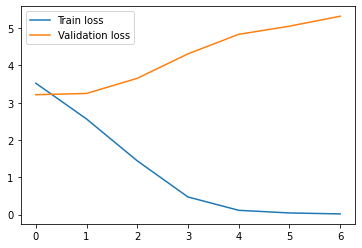

In [22]:
main(epochs = 7, modelPath = 'bnNet2.pth', modelType = 'bnNet')

#### Added Layers

preprocessing
training
Epoch: 0 	Training Loss: 3.755414 	Validation Loss: 3.621101
Validation Loss decreased inf -> 3.621101
Epoch: 1 	Training Loss: 3.477234 	Validation Loss: 3.351276
Validation Loss decreased 3.621101 -> 3.351276
Epoch: 2 	Training Loss: 3.303887 	Validation Loss: 3.285202
Validation Loss decreased 3.351276 -> 3.285202
Epoch: 3 	Training Loss: 3.199001 	Validation Loss: 3.134609
Validation Loss decreased 3.285202 -> 3.134609
Epoch: 4 	Training Loss: 3.079044 	Validation Loss: 3.029494
Validation Loss decreased 3.134609 -> 3.029494
Epoch: 5 	Training Loss: 2.985824 	Validation Loss: 3.024104
Validation Loss decreased 3.029494 -> 3.024104
Epoch: 6 	Training Loss: 2.900713 	Validation Loss: 3.023559
Validation Loss decreased 3.024104 -> 3.023559
Accuracy of the network on the 10000 test images: 23.927039 %
F1 score : 0.23927038626609443


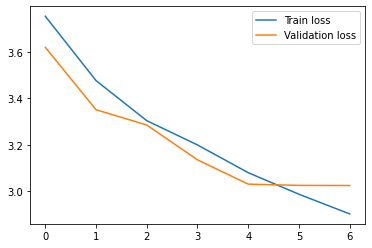

In [23]:
main(epochs = 7, modelPath = 'layerNet2.pth', modelType = 'layerNet')

#### Dropout

preprocessing
training
Epoch: 0 	Training Loss: 3.808936 	Validation Loss: 3.655157
Validation Loss decreased inf -> 3.655157
Epoch: 1 	Training Loss: 3.589509 	Validation Loss: 3.434024
Validation Loss decreased 3.655157 -> 3.434024
Epoch: 2 	Training Loss: 3.430573 	Validation Loss: 3.281728
Validation Loss decreased 3.434024 -> 3.281728
Epoch: 3 	Training Loss: 3.279819 	Validation Loss: 3.208360
Validation Loss decreased 3.281728 -> 3.208360
Epoch: 4 	Training Loss: 3.157630 	Validation Loss: 3.131332
Validation Loss decreased 3.208360 -> 3.131332
Epoch: 5 	Training Loss: 3.045019 	Validation Loss: 3.046390
Validation Loss decreased 3.131332 -> 3.046390
Epoch: 6 	Training Loss: 2.935370 	Validation Loss: 3.012573
Validation Loss decreased 3.046390 -> 3.012573
Accuracy of the network on the 10000 test images: 22.532189 %
F1 score : 0.22532188841201717


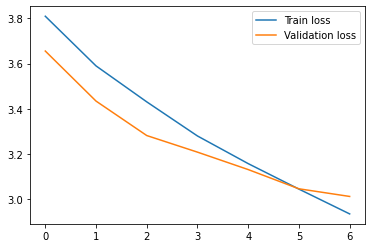

In [24]:
main(epochs = 7, modelPath = 'dropoutNet2.pth', modelType = 'dropoutNet')

#### Different Optimizers (*SGD*)

preprocessing
training
Epoch: 0 	Training Loss: 3.830436 	Validation Loss: 3.666962
Validation Loss decreased inf -> 3.666962
Epoch: 1 	Training Loss: 3.548994 	Validation Loss: 3.550342
Validation Loss decreased 3.666962 -> 3.550342
Epoch: 2 	Training Loss: 3.389076 	Validation Loss: 3.469578
Validation Loss decreased 3.550342 -> 3.469578
Epoch: 3 	Training Loss: 3.246128 	Validation Loss: 3.386439
Validation Loss decreased 3.469578 -> 3.386439
Epoch: 4 	Training Loss: 3.104292 	Validation Loss: 3.233563
Validation Loss decreased 3.386439 -> 3.233563
Epoch: 5 	Training Loss: 2.985016 	Validation Loss: 3.159169
Validation Loss decreased 3.233563 -> 3.159169
Epoch: 6 	Training Loss: 2.878749 	Validation Loss: 3.191268
Accuracy of the network on the 10000 test images: 23.122318 %
F1 score : 0.23122317596566527


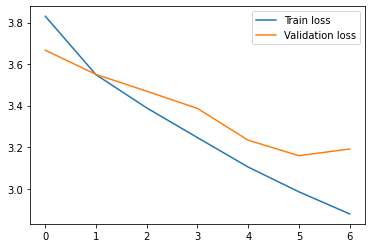

In [25]:
main(epochs = 7, modelPath = 'SGDBasicNet2.pth', optimizerType = 'SGD')

#### Different Pooling (Max pooling)

preprocessing
training
Epoch: 0 	Training Loss: 3.590492 	Validation Loss: 3.358264
Validation Loss decreased inf -> 3.358264
Epoch: 1 	Training Loss: 3.166280 	Validation Loss: 3.117415
Validation Loss decreased 3.358264 -> 3.117415
Epoch: 2 	Training Loss: 2.920867 	Validation Loss: 2.994300
Validation Loss decreased 3.117415 -> 2.994300
Epoch: 3 	Training Loss: 2.604453 	Validation Loss: 2.987507
Validation Loss decreased 2.994300 -> 2.987507
Epoch: 4 	Training Loss: 2.202755 	Validation Loss: 3.137461
Epoch: 5 	Training Loss: 1.742081 	Validation Loss: 3.508307
Epoch: 6 	Training Loss: 1.262266 	Validation Loss: 4.020225
Accuracy of the network on the 10000 test images: 23.336910 %
F1 score : 0.23336909871244635


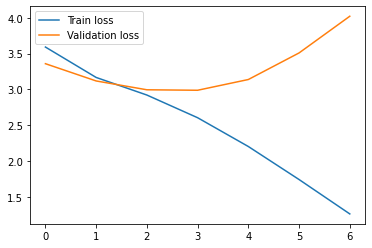

In [26]:
main(epochs = 7, modelPath = 'maxpoolNet2.pth', modelType = 'maxpoolNet')

#### Basic Augmentation

preprocessing
training
Epoch: 0 	Training Loss: 3.672529 	Validation Loss: 3.478535
Validation Loss decreased inf -> 3.478535
Epoch: 1 	Training Loss: 3.400020 	Validation Loss: 3.357773
Validation Loss decreased 3.478535 -> 3.357773
Epoch: 2 	Training Loss: 3.287075 	Validation Loss: 3.316731
Validation Loss decreased 3.357773 -> 3.316731
Epoch: 3 	Training Loss: 3.203005 	Validation Loss: 3.245356
Validation Loss decreased 3.316731 -> 3.245356
Epoch: 4 	Training Loss: 3.144809 	Validation Loss: 3.250501
Epoch: 5 	Training Loss: 3.112519 	Validation Loss: 3.127586
Validation Loss decreased 3.245356 -> 3.127586
Epoch: 6 	Training Loss: 3.026395 	Validation Loss: 3.122794
Validation Loss decreased 3.127586 -> 3.122794
Accuracy of the network on the 10000 test images: 22.907725 %
F1 score : 0.2290772532188841


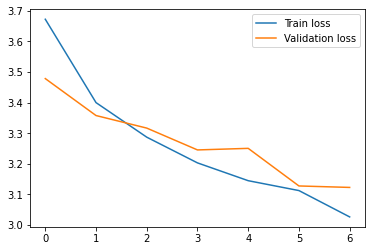

In [28]:
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
    transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])

main(epochs = 7, modelPath = 'transformNet2.pth',  transform = transform_aug)

#### Different Activations

preprocessing
training
Epoch: 0 	Training Loss: 4.048840 	Validation Loss: 4.050672
Validation Loss decreased inf -> 4.050672
Epoch: 1 	Training Loss: 4.044942 	Validation Loss: 4.050672
Validation Loss decreased 4.050672 -> 4.050672
Accuracy of the network on the 10000 test images: 8.798283 %
F1 score : 0.08798283261802575


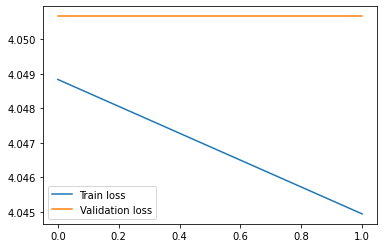

In [25]:
main(epochs = 2, modelPath = 'activationNet2.pth', modelType = 'activationNet')